# Uldir Guild Awards Analysis

<ul>
<li><a href="#collect">Collect Analysis Data</a></li>
<li><a href="#taloc">Taloc</a></li>
<li><a href="#mother">MOTHER</a></li>
<li><a href="#zekvoz">Zek'voz</a>
<li><a href="#vectis">Vectis</a>
<li><a href="#fetid">Fetid</a>
<li><a href="#zul">Zul</a>
<li><a href="#mythrax">Mythrax</a>
<li><a href="#ghuun">G'Huun</a>
<li><a href="#overall">Overall</a>
    <ul>
        <li><a href="#pots">Most Pots Used</a></li>
        <li><a href="#healthstone">Most Healthstones/Pots Used</a></li>
        <li><a href="#rankings">Rankings</a></li>
        <li><a href="#prog-parse">Highest Parse on Progression Kill</a></li>
    </ul></li>
</ul>

This notebook extracts information from the [Warcraft Logs](https://www.warcraftlogs.com/) API to produce data for the [Last Pull](https://tempestgorg.enjin.com/) Uldir guild awards.

## Setup

In [1]:
# Import all required libraries and modules
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import warcraft_logs_fn as wl
import log_analysis as la
import api_key
%matplotlib inline

In [2]:
# Import key
api_key = api_key.key

In [4]:
# Update player info
player_list = pd.read_csv('player_list.csv')
player_list

,player,primary_role,alt,tier_end,tier_start,start_date
0,Vaelyra,mdps,NaN,NaN,True,NaN
1,Metonymy,rdps,NaN,NaN,True,NaN
2,Brian,mdps,NaN,NaN,True,NaN
3,Petrol,rdps,NaN,NaN,True,NaN
4,Ayriea,rdps,NaN,NaN,True,NaN
5,Stradlock,rdps,NaN,NaN,True,NaN
6,Uuglei,mdps,NaN,NaN,True,NaN
7,Earrl,tank,NaN,NaN,True,NaN
8,Illestra,healer,NaN,NaN,True,NaN
9,Kamer,mdps,NaN,NaN,True,NaN


In [30]:
# Update changed names
elz_idx = player_list.query('player == "Grimbrondal"').index
player_list.at[elz_idx, 'player'] = 'Grombrindal'

# Test
player_list.query('player == "Grombrindal"')

,player,primary_role,alt,tier_end,tier_start,start_date
10,Grombrindal,mdps,Cagliostro,False,True,NaN


In [15]:
def add_alts(previous_name, new_name, player_list, update=False):
    idx = player_list[player_list.player == previous_name].index
    if update:
        player_list.at[idx, 'player'] = new_name
        player_list.at[idx, 'alt'] = previous_name
    else:
        player_list.at[idx, 'alt'] = new_name

In [17]:
# Add player alts
add_alts('Ayriea', 'Invinceble', player_list)
add_alts('Vaelyra', 'Noraela', player_list)
add_alts('Sumi', 'Brassi', player_list)

# Test
player_list

,player,primary_role,alt,tier_end,tier_start,start_date
0,Vaelyra,mdps,Noraela,NaN,True,NaN
1,Metonymy,rdps,NaN,NaN,True,NaN
2,Brian,mdps,NaN,NaN,True,NaN
3,Petrol,rdps,NaN,NaN,True,NaN
4,Ayriea,rdps,Invinceble,NaN,True,NaN
5,Stradlock,rdps,NaN,NaN,True,NaN
6,Uuglei,mdps,NaN,NaN,True,NaN
7,Earrl,tank,NaN,NaN,True,NaN
8,Illestra,healer,NaN,NaN,True,NaN
9,Kamer,mdps,NaN,NaN,True,NaN


Alts were correctly added.

In [19]:
# Add new players
new_players = pd.DataFrame([
    {'player': 'Kopyelock', 
     'primary_role': 'rdps', 
     'alt': np.nan,
     'tier_end': True,
     'tier_start': False,
     'start_date': 'Oct-16-18'}, 
    {'player': 'Velsummers', 
     'primary_role': 'healer', 
     'alt': np.nan,
     'tier_end': True,
     'tier_start': True,
     'start_date': np.nan}], 
    columns=['player', 'primary_role', 'alt', 
             'tier_end', 'tier_start', 'start_date'])

new_players

,player,primary_role,alt,tier_end,tier_start,start_date
0,Kopyelock,rdps,NaN,True,False,Oct-16-18
1,Velsummers,healer,NaN,True,True,NaN


In [22]:
# Add to player_list
player_list = pd.concat([player_list, new_players])

# Test
assert player_list.tail(2).player.isin(['Kopyelock', 'Velsummers']).sum() == 2

In [31]:
# Confirm end of tier players
end_of_tier = ['Vaelyra', 'Metonymy', 'Brian', 'Petrol', 'Ayriea', 
               'Stradlock', 'Uuglei', 'Earrl', 'Illestra', 'Grombrindal', 
               'Tawn', 'Draigo', 'Psychodruid', 'Sumi', 'Toy', 'Mythrose', 
               'Shadowbaine', 'Acturus', 'Velryssa', 'Jampers', 'Vampyric', 
               'Kopyelock', 'Velsummers']

player_list.tier_end = player_list.player.isin(end_of_tier)

# Test
assert player_list.tier_end.sum() == len(end_of_tier)

In [32]:
# Update saved player list
player_list.to_csv('player_list.csv', index=False)

In [33]:
# Collect guild info
guild_info = wl.GUILD_INFO

# Extract logs
log_info = wl.get_logs(api_key, guild_info, log_start=1536202744238)
wl.save_logs(log_info, api_key, guild_info, log_start=1536202744238)

# Create boss list
boss_list = ['Taloc', 
             'MOTHER', 
             'Fetid Devourer', 
             "Zek'voz", 
             'Vectis',
             'Zul', 
             'Mythrax', 
             "G'Huun"]

# Extract fight details and save
fight_df = wl.extract_fights(boss_list)
wl.create_master_list(log_info, fight_df)

Creating file vTWVFQfwcHztbnKL
Creating file JgqKCkP7p3nAd1Ha
Creating file GbryNmfD98zcH6Jn
Creating file Hg83cdfhJaLyp6rG
Creating file k3LJpfYV1Nv2t8zq
Creating file mPaDJCdt4rWQkA7V
Creating file PYArFRQJ9MCT6jXy
Creating file rTPDJGpVXFZwNkA7
Creating file 9t1JjYfvbZkyWCGP
Creating file ac1rQnYvZWRjypVD
Creating file rMPLdKwCcH78Yz9q
Creating file 1rnktHXvcTWD2JzL
Creating file 96XVRq3ZJ2pGk1YC
Creating file FGhKD9AmjVpRMYw2
Creating file jaqf6V3Q4vNmDFdR
Creating file d3P97v4DpLHmyZkW
Creating file 6JMd2cmzFk8Qa1gj
Creating file ArqaVzbYtW7BG2Cx
Creating file 81HkLmCMRdAg6rNJ
Creating file nxf6krQP8Bvty9V2
Creating file V8Nd6ntR4PZMmLQW
Creating file VkQfpqZHB419zDcr
Creating file GdR1r6pVwA9TWXbJ
Creating file gcfCXbY14qDyhZtv
Creating file agwcpfjKbLTHrd1W
Creating file nqKDNkYjg9hzTwL6
Creating file T7xMvwtyG9YaP6k3
Creating file DycbAK6f1PL7Wpkd
Creating file rVcMgwvmPfDHYZ1a
Creating file VJQh2mdxkYypc196

All files created.

Log ID 1rnktHXvcTWD2JzL done.
Log ID 4mzCD2x9hnqZ

In [34]:
# Check all players added
fight_df.player_name.unique()

array(['Petrol', 'Illestra', 'Tawn', 'Liavre', 'Shadowbaine', 'Metonymy',
       'Draigo', 'Psychodruid', 'Kopyelock', 'Mythrose', 'Brian', 'Sumi',
       'Vaelyra', 'Katanescence', 'Acturus', 'Toy', 'Ayriea', 'Jampers',
       'Earrl', 'Grombrindal', 'Velryssa', 'Vampyric', 'Cagliostro',
       'Dough', 'Stradlock', 'Uuglei', 'Kiwisoda', 'Noraela', 'Katheals',
       'Invinceble', 'Brassi', 'Humanraptor', 'Czef', 'Quasilloyd',
       'Oakinon', 'Heavenlylite'], dtype=object)

Missing two player adds: 
1. Kiwisoda as main
2. Katheals as alt

In [35]:
add_alts('Katanescence', 'Katheals', player_list)

new_players = pd.DataFrame([
    {'player': 'Kiwisoda', 
     'primary_role': 'rdps', 
     'alt': np.nan,
     'tier_end': True,
     'tier_start': False,
     'start_date': 'Oct-23-18'}], 
    columns=['player', 'primary_role', 'alt', 
             'tier_end', 'tier_start', 'start_date'])

player_list = pd.concat([player_list, new_players])

# Test
assert player_list.alt.count() == 5
assert player_list.shape[0] == 28

In [36]:
# Update player list
player_list.to_csv('player_list.csv', index=False)

<a id='collect'></a>
## Collect Analysis Data

In [2]:
# Import key and player list
api_key = api_key.key
player_list = pd.read_csv('player_list.csv')

# Collect guild info
guild_info = wl.GUILD_INFO

# Extract logs
log_info = wl.get_logs(api_key, guild_info, log_start=1536202744238)
wl.save_logs(log_info, api_key, guild_info, log_start=1536202744238)

# Create boss list
boss_list = ['Taloc', 
             'MOTHER', 
             'Fetid Devourer', 
             "Zek'voz", 
             'Vectis',
             'Zul', 
             'Mythrax', 
             "G'huun"]

# Extract fight details and save
fight_df = wl.extract_fights(boss_list)
wl.create_master_list(log_info, fight_df)

master_list = pd.read_csv('master_list.csv')
master_list = master_list[master_list.difficulty == 5] # Get mythic only


All files created.

Log ID 1rnktHXvcTWD2JzL done.
Log ID 4mzCD2x9hnqZb3KG done.
Log ID 4zpRXjQA3Fhg9KdJ done.
Log ID 6JMd2cmzFk8Qa1gj done.
Log ID 81HkLmCMRdAg6rNJ done.
Log ID 96XVRq3ZJ2pGk1YC done.
Log ID 9t1JjYfvbZkyWCGP done.
Log ID ac1rQnYvZWRjypVD done.
Log ID agwcpfjKbLTHrd1W done.
Log ID ArqaVzbYtW7BG2Cx done.
Log ID ArVhTvdPmLf9JHjR done.
Log ID bKHF3fdQCJqGZzPt done.
Log ID d3P97v4DpLHmyZkW done.
Log ID dgkHRTaMQGJ7Zm3C done.
Log ID dHMk9Czm4GWRF8Tx done.
Log ID dV3RWaQchfv9zT64 done.
Log ID DycbAK6f1PL7Wpkd done.
Log ID FGhKD9AmjVpRMYw2 done.
Log ID fK7dCTJBknH64Xpz done.
Log ID FQwrJhRb2dypT6PC done.
Log ID GbryNmfD98zcH6Jn done.
Log ID gcfCXbY14qDyhZtv done.
Log ID GdR1r6pVwA9TWXbJ done.
Log ID Hg83cdfhJaLyp6rG done.
Log ID HQBfXNr6kqhP4dm1 done.
Log ID jaqf6V3Q4vNmDFdR done.
Log ID Jd2kb7C9PncfqN1v done.
Log ID JgqKCkP7p3nAd1Ha done.
Log ID JTrPMkjvCH6NtR7x done.
Log ID k3LJpfYV1Nv2t8zq done.
Log ID kgfWrMTP93417Yja done.
Log ID kKrTnBRXgtW3aJHw done.
Log ID KmVAr4DMhcvF

In [3]:
# Confirm boss IDs
boss_info = ['boss_id', 'boss_name']
master_list.drop_duplicates(subset=boss_info)[boss_info]

,boss_id,boss_name
0,2135,Mythrax
833,2136,Zek'voz
1213,2128,Fetid Devourer
1413,2145,Zul
2332,2122,G'huun
3670,2144,Taloc
3690,2141,MOTHER
3730,2134,Vectis


<a id='taloc'></a>
## Taloc

Blood Storm: 270290

In [195]:
# Damage done by Blood Storm
taloc = wl.damage_taken(api_key, master_list, 270290, boss_id=2144, hit_type='tickCount')
taloc.head()

Player added: Stradlock
Player added: Psychodruid
Player added: Metonymy
Player added: Ayriea
Player added: Katanescence
Player added: Kopyelock
Player added: Brian
Player added: Vampyric
Player added: Toy
Player added: Petrol
Player added: Acturus
Player added: Jampers
Player added: Draigo
Player added: Liavre
Player added: Velryssa
Player added: Earrl
Player added: Uuglei
Player added: Kiwisoda
Player added: Grombrindal
Player added: Shadowbaine
Player added: Cagliostro
Player added: Liavre
Player added: Earrl
Player added: Draigo
Player added: Jampers
Player added: Toy
Player added: Metonymy
Player added: Velryssa
Player added: Uuglei
Player added: Psychodruid
Player added: Stradlock
Player added: Mythrose
Player added: Petrol
Player added: Vampyric
Player added: Tawn
Player added: Shadowbaine
Player added: Ayriea
Player added: Brian
Player added: Acturus
Player added: Sumi
Player added: Vaelyra
Player added: Illestra
Player added: Katanescence
Player added: Liavre
Player added: Uug

,log_id,spell_id,player,hits,damage_taken
0,ArqaVzbYtW7BG2Cx,270290,Stradlock,5,109541
1,ArqaVzbYtW7BG2Cx,270290,Psychodruid,9,196013
2,ArqaVzbYtW7BG2Cx,270290,Metonymy,7,153565
3,ArqaVzbYtW7BG2Cx,270290,Ayriea,6,131141
4,ArqaVzbYtW7BG2Cx,270290,Katanescence,14,314003


In [196]:
# Save info
taloc.to_csv('guild_awards/taloc_bloodstorm_data.csv', index=False)
# Complete analysis
bloodstorm = la.clean_fight_count(taloc, master_list, player_list, 2144, ['hits', 'damage_taken'])
damage_taken = la.find_count_order(bloodstorm, 5, 'hits')
damage_taken

,player,hits,damage_taken,fight_count,primary_role,av_count
20,Tawn,24,512953,13,rdps,1.846154
17,Shadowbaine,39,838239,16,rdps,2.437500
8,Jampers,42,889103,15,healer,2.800000
1,Ayriea,37,808742,13,rdps,2.846154
19,Sumi,28,626483,8,rdps,3.500000
15,Petrol,67,1414053,17,rdps,3.941176
18,Stradlock,52,1070448,13,rdps,4.000000
3,Dough,42,923870,10,rdps,4.200000
13,Metonymy,79,1651819,15,rdps,5.266667
7,Illestra,85,1714369,16,healer,5.312500


In [197]:
# Save data
damage_taken.to_csv('guild_awards/taloc_bloodstorm_hits.csv', index=False)

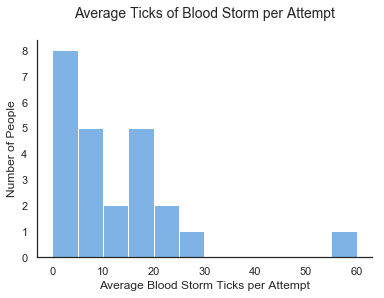

In [198]:
bins=np.arange(0, damage_taken.av_count.max() + 5, 5)
plt.hist(damage_taken.av_count, bins=bins, align='mid', color=palette[-1], edgecolor='white')
plt.title('Average Ticks of Blood Storm per Attempt\n', fontsize=14)
plt.xlabel('Average Blood Storm Ticks per Attempt')
plt.ylabel('Number of People');
sns.despine()

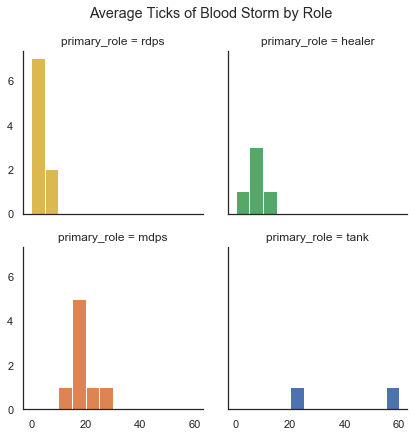

In [67]:
g = sns.FacetGrid(damage_taken, col='primary_role', hue='primary_role', 
                  col_wrap=2, palette=palette)
g.map(plt.hist, "av_count", bins=bins, align='mid', edgecolor='white');
for i in np.arange(2,4):
    g.axes[i].set_xlabel('')
plt.suptitle('Average Ticks of Blood Storm by Role', y=1.04);

In [59]:
print(damage_taken.av_count.mean())
print(damage_taken.av_count.median())

12.475472240178123
7.219230769230769


In [60]:
damage_taken.fight_count.max()

17

<a id='mother'></a>
## MOTHER

Spell IDs for Uldir Defensive Beam:
- 284631
- 268253

In [3]:
# Damage done by Uldir Defensive Beam first ID
id_284631 = wl.damage_taken(api_key, master_list, 284631, boss_id=2141, hit_type='tickCount')

Player added: Liavre
Player added: Earrl
Player added: Velryssa
Player added: Vampyric
Player added: Illestra
Player added: Metonymy
Player added: Petrol
Player added: Brian
Player added: Mythrose
Player added: Katanescence
Player added: Stradlock
Player added: Earrl
Player added: Sumi
Player added: Psychodruid
Player added: Ayriea
Player added: Tawn
Player added: Jampers
Player added: Dough
Player added: Uuglei
Player added: Vaelyra
Player added: Acturus
Player added: Draigo
Player added: Vaelyra
Player added: Shadowbaine
Player added: Draigo
Player added: Metonymy
Player added: Illestra
Player added: Mythrose
Player added: Brian
Player added: Liavre
Player added: Grombrindal
Player added: Liavre
Player added: Vaelyra
Player added: Earrl
Player added: Metonymy
Player added: Toy
Player added: Psychodruid
Player added: Acturus
Player added: Draigo
Player added: Jampers
Player added: Uuglei
Player added: Ayriea
Player added: Vaelyra
Player added: Psychodruid
Player added: Mythrose
Player

In [71]:
id_284631.head()

,log_id,spell_id,player,hits,damage_taken
0,ArqaVzbYtW7BG2Cx,284631,Liavre,2,490750
1,ArqaVzbYtW7BG2Cx,284631,Earrl,1,218991
2,ArVhTvdPmLf9JHjR,284631,Velryssa,2,373090
3,ArVhTvdPmLf9JHjR,284631,Vampyric,3,647013
4,ArVhTvdPmLf9JHjR,284631,Illestra,5,1114091


In [4]:
# Damage done by Uldir Defensive Beam second ID
id_268253 = wl.damage_taken(api_key, master_list, 268253, boss_id=2141, hit_type='tickCount')

Player added: Uuglei
Player added: Liavre
Player added: Sumi
Player added: Brian
Player added: Dough
Player added: Jampers
Player added: Mythrose
Player added: Illestra
Player added: Stradlock
Player added: Vaelyra
Player added: Draigo
Player added: Tawn
Player added: Earrl
Player added: Velryssa
Player added: Metonymy
Player added: Acturus
Player added: Katanescence
Player added: Brian
Player added: Earrl
Player added: Cagliostro
Player added: Katanescence
Player added: Jampers
Player added: Brian
Player added: Brian
Player added: Jampers
Player added: Tawn
Player added: Illestra
Player added: Uuglei
Player added: Velryssa
Player added: Metonymy
Player added: Uuglei


In [5]:
beams = pd.concat([id_284631, id_268253])
beams.head()

,log_id,spell_id,player,hits,damage_taken
0,ArqaVzbYtW7BG2Cx,284631,Liavre,2,490750
1,ArqaVzbYtW7BG2Cx,284631,Earrl,1,218991
2,ArVhTvdPmLf9JHjR,284631,Velryssa,2,373090
3,ArVhTvdPmLf9JHjR,284631,Vampyric,3,647013
4,ArVhTvdPmLf9JHjR,284631,Illestra,5,1114091


In [190]:
bins = np.arange(0, 0.75, 0.05)

          player  hits  damage_taken  fight_count primary_role  av_count
8        Jampers     1        231227           32       healer  0.031250
1         Ayriea     1        240940           29         rdps  0.034483
13        Petrol     2        414573           32         rdps  0.062500
15   Shadowbaine     1        216062           15         rdps  0.066667
20        Uuglei     2        397562           29         mdps  0.068966
22      Vampyric     3        647013           32         mdps  0.093750
19           Toy     2        408796           14         mdps  0.142857
0        Acturus     5       1125920           32       healer  0.156250
3          Dough     3        589576           18         rdps  0.166667
14   Psychodruid     5       1109483           30         rdps  0.166667
18          Tawn     6       1354489           31         rdps  0.193548
12      Mythrose     6       1401265           31       healer  0.193548
16     Stradlock     4        846814           19  

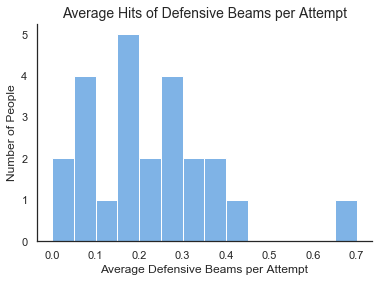

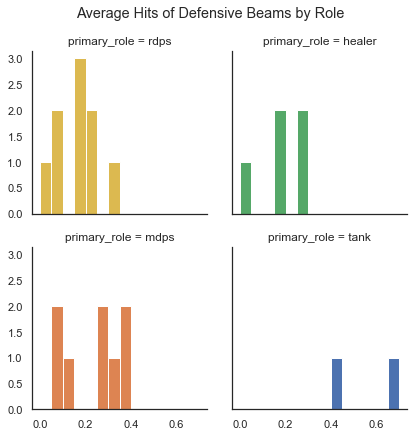

Mean is 0.222895 per attempt.
Median is 0.202037 per attempt.
Max attempts by player is 32.


In [191]:
la.collect_stats(data=beams, master_list=master_list, player_list=player_list, 
                 boss_name='MOTHER', boss_id=2141, spell_name='Defensive Beams', 
                 analysis_columns=['hits', 'damage_taken'], min_attempts=5, bins=bins)

<a id='zekvoz'></a>
## Zek'voz

### Surging Darkness 
Rings damage, IDs:
- 275084
- 265451
- 265454
- 265452

In [72]:
ring_ids = [275084, 265451, 265454, 265452]
surging_darkness = pd.DataFrame([], columns=['log_id', 'spell_id','player', 
                                             'hits', 'damage_taken'])

for ring_id in ring_ids:
    id_df = wl.damage_taken(api_key, master_list, ring_id, boss_id=2136, hit_type='hitCount')
    surging_darkness = pd.concat([surging_darkness, id_df])

Player added: Ayriea
Player added: Stradlock
Player added: Petrol
Player added: Vampyric
Player added: Sumi
Player added: Katanescence
Player added: Petrol
Player added: Vampyric
Player added: Stradlock
Player added: Draigo
Player added: Uuglei
Player added: Toy
Player added: Kiwisoda
Player added: Shadowbaine
Player added: Brian
Player added: Ayriea
Player added: Mythrose
Player added: Vampyric
Player added: Ayriea
Player added: Vampyric
Player added: Psychodruid
Player added: Sumi
Player added: Draigo
Player added: Vampyric
Player added: Velryssa
Player added: Sumi
Player added: Ayriea
Player added: Metonymy
Player added: Stradlock
Player added: Ayriea
Player added: Mythrose
Player added: Velryssa
Player added: Velryssa
Player added: Liavre
Player added: Earrl
Player added: Vaelyra
Player added: Stradlock
Player added: Draigo
Player added: Katanescence
Player added: Psychodruid
Player added: Vampyric
Player added: Petrol
Player added: Mythrose
Player added: Brian
Player added: Acturu

Player added: Petrol
Player added: Earrl
Player added: Illestra
Player added: Liavre
Player added: Ayriea
Player added: Vampyric
Player added: Cagliostro
Player added: Toy
Player added: Acturus
Player added: Sumi
Player added: Jampers
Player added: Psychodruid
Player added: Draigo
Player added: Shadowbaine
Player added: Stradlock
Player added: Grombrindal
Player added: Metonymy
Player added: Shadowbaine
Player added: Illestra
Player added: Sumi
Player added: Acturus
Player added: Toy
Player added: Mythrose
Player added: Stradlock
Player added: Psychodruid
Player added: Vaelyra
Player added: Liavre
Player added: Tawn
Player added: Petrol
Player added: Draigo
Player added: Earrl
Player added: Psychodruid
Player added: Tawn
Player added: Vaelyra
Player added: Kiwisoda
Player added: Brian
Player added: Mythrose
Player added: Metonymy
Player added: Earrl
Player added: Katanescence
Player added: Uuglei
Player added: Psychodruid
Player added: Mythrose
Player added: Draigo
Player added: Uuglei

In [73]:
surging_darkness.head()

,log_id,spell_id,player,hits,damage_taken
0,4zpRXjQA3Fhg9KdJ,275084,Ayriea,1,141487
1,4zpRXjQA3Fhg9KdJ,275084,Stradlock,1,83356
2,4zpRXjQA3Fhg9KdJ,275084,Petrol,1,140762
3,4zpRXjQA3Fhg9KdJ,275084,Vampyric,0,0
4,4zpRXjQA3Fhg9KdJ,275084,Sumi,0,0


In [188]:
bins = np.arange(0.1, 0.75, 0.05)

          player  hits  damage_taken  fight_count primary_role  av_count
15        Petrol    15       2102365          118         rdps  0.127119
24      Vampyric    16       1747867          118         mdps  0.135593
3          Dough     6        801490           38         rdps  0.157895
6    Grombrindal    15       1857968           87         mdps  0.172414
19          Sumi    21       2927359          117         rdps  0.179487
1         Ayriea    21       2926356          110         rdps  0.190909
13      Metonymy    24       3382639          118         rdps  0.203390
2          Brian    25       3347369          114         mdps  0.219298
23       Vaelyra    25       3046220          111         mdps  0.225225
11     Kopyelock     3        437293           12         rdps  0.250000
0        Acturus    31       4233248          117       healer  0.264957
21           Toy    27       3067242           95         mdps  0.284211
20          Tawn    24       3286301           80  

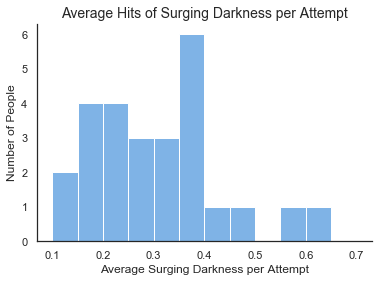

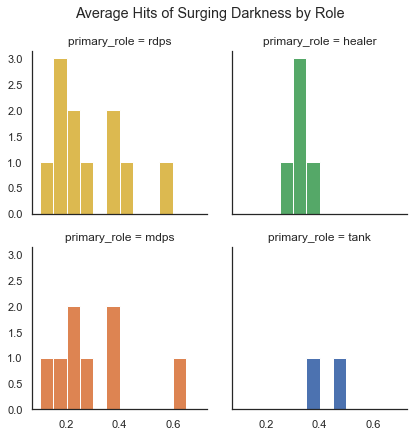

Mean is 0.311342 per attempt.
Median is 0.308120 per attempt.
Max attempts by player is 118.


In [189]:
la.collect_stats(data=surging_darkness, master_list=master_list, player_list=player_list, 
                 boss_name="Zek'voz", boss_id=2136, spell_name='Surging Darkness', 
                 analysis_columns=['hits', 'damage_taken'], min_attempts=5, bins=bins)

### Jagged Mandible
264210

In [82]:
add_dot = wl.damage_taken(api_key, master_list, 264210, boss_id=2136, hit_type='tickCount')

Player added: Uuglei
Player added: Liavre
Player added: Shadowbaine
Player added: Sumi
Player added: Illestra
Player added: Stradlock
Player added: Mythrose
Player added: Brian
Player added: Psychodruid
Player added: Katanescence
Player added: Velryssa
Player added: Vampyric
Player added: Acturus
Player added: Vaelyra
Player added: Petrol
Player added: Tawn
Player added: Metonymy
Player added: Ayriea
Player added: Illestra
Player added: Uuglei
Player added: Brian
Player added: Liavre
Player added: Shadowbaine
Player added: Kopyelock
Player added: Jampers
Player added: Vaelyra
Player added: Acturus
Player added: Katanescence
Player added: Velryssa
Player added: Vampyric
Player added: Shadowbaine
Player added: Cagliostro
Player added: Acturus
Player added: Illestra
Player added: Liavre
Player added: Dough
Player added: Metonymy
Player added: Jampers
Player added: Vampyric
Player added: Sumi
Player added: Ayriea
Player added: Katanescence
Player added: Toy
Player added: Vaelyra
Player add

In [83]:
add_dot.head()

,log_id,spell_id,player,hits,damage_taken
0,4zpRXjQA3Fhg9KdJ,264210,Uuglei,149,3524991
1,4zpRXjQA3Fhg9KdJ,264210,Liavre,218,5274285
2,4zpRXjQA3Fhg9KdJ,264210,Shadowbaine,67,1602738
3,4zpRXjQA3Fhg9KdJ,264210,Sumi,72,1821281
4,4zpRXjQA3Fhg9KdJ,264210,Illestra,105,2556157


In [186]:
bins=np.arange(3.5, 11.5, 0.5)

          player  hits  damage_taken  fight_count primary_role   av_count
1         Ayriea   423      10515882          110         rdps   3.845455
14   Psychodruid   454      11248420          118         rdps   3.847458
15   Shadowbaine   254       6280059           52         rdps   4.884615
11      Metonymy   581      14457548          118         rdps   4.923729
18          Tawn   403       9905375           80         rdps   5.037500
17          Sumi   593      14903530          117         rdps   5.068376
13        Petrol   618      15562945          118         rdps   5.237288
6        Jampers   401       8757868           75       healer   5.346667
16     Stradlock   662      16560471          116         rdps   5.706897
5       Illestra   767      18405110          117       healer   6.555556
12      Mythrose   761      16752963          106       healer   7.179245
23      Velryssa   761      18842366          100         mdps   7.610000
9      Kopyelock    93       2327887  

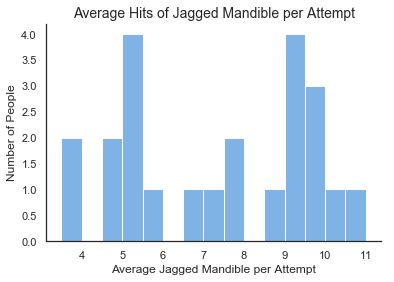

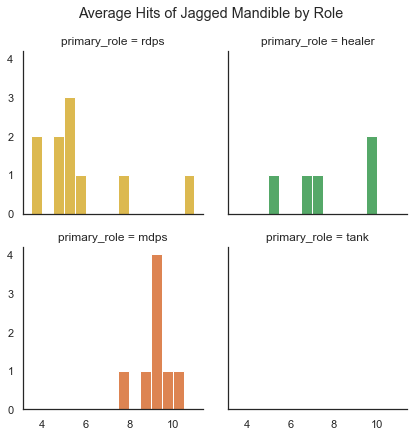

Mean is 7.369750 per attempt.
Median is 7.610000 per attempt.
Max attempts by player is 118.


In [187]:
la.collect_stats(data=add_dot, master_list=master_list, player_list=player_list, 
                 boss_name="Zek'voz", boss_id=2136, spell_name='Jagged Mandible', 
                 analysis_columns=['hits', 'damage_taken'], min_attempts=10, bins=bins)

### Interrupts
Spell IDs:
- Mage: Counterspell (2139), ~~Dragon's Breath (31661)~~
- Druid: Solar Beam (78675), Skull Bash (106839)
- Warrior: Pummel (6552), Intimidating Shout (5246)
- Hunter: Counter Shot (147362), Concussive Shot (5116)
- Rogue: Kick (1766), Kidney Shot (408)
- DH: Consume Magic (183752)
- Shaman: Wind Shear (57994), Lightning/Cap Totem (192058)
- Paladin: Rebuke (96231), Hammer of Justice (853)
- Monk: Spear Hand Strike (116705), Leg Sweep (119381)

In [101]:
spell_ids = [2139, 78675, 106839, 6552, 5246, 147362, 5116, 1766, 408, 
             183752, 57994, 192058, 96231, 853, 171140, 116705, 119381]

In [102]:
# Double check length to prevent maxing query limit
len(spell_ids)

17

In [103]:
interrupts = pd.DataFrame([], columns=['log_id', 'spell_id', 'player', 'count'])

for spell_id in spell_ids:
    try:
        print('Spell Id:', spell_id)
        spell_df = wl.cast_count(api_key, master_list, spell_id, boss_id=2136)
        interrupts = pd.concat([interrupts, spell_df])
    except:
        continue

Spell Id: 2139
Player added: Tawn
Player added: Metonymy
Player added: Petrol
Player added: Tawn
Player added: Petrol
Player added: Metonymy
Player added: Petrol
Player added: Metonymy
Player added: Petrol
Player added: Metonymy
Player added: Tawn
Player added: Tawn
Player added: Petrol
Player added: Metonymy
Player added: Tawn
Player added: Petrol
Player added: Metonymy
Player added: Metonymy
Player added: Petrol
Player added: Petrol
Player added: Metonymy
Player added: Tawn
Player added: Petrol
Player added: Metonymy
Player added: Tawn
Player added: Petrol
Player added: Tawn
Player added: Metonymy
Player added: Petrol
Player added: Tawn
Player added: Metonymy
Player added: Tawn
Player added: Metonymy
Player added: Tawn
Player added: Petrol
Spell Id: 78675
Player added: Psychodruid
Player added: Psychodruid
Player added: Psychodruid
Player added: Psychodruid
Player added: Psychodruid
Player added: Psychodruid
Player added: Psychodruid
Player added: Psychodruid
Player added: Psychodrui

Player added: Liavre
Player added: Liavre
Player added: Liavre
Player added: Liavre
Spell Id: 183752
Player added: Vaelyra
Player added: Vampyric
Player added: Vampyric
Player added: Vaelyra
Player added: Vaelyra
Player added: Vampyric
Player added: Vampyric
Player added: Vaelyra
Player added: Vampyric
Player added: Vaelyra
Player added: Vampyric
Player added: Vampyric
Player added: Vaelyra
Player added: Vaelyra
Player added: Vampyric
Player added: Vaelyra
Player added: Vampyric
Player added: Vampyric
Player added: Vaelyra
Player added: Vaelyra
Player added: Vampyric
Player added: Vampyric
Player added: Vaelyra
Player added: Vampyric
Player added: Vaelyra
Spell Id: 57994
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra
Spell Id: 192058
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra
Play

In [93]:
interrupts.head()

,log_id,spell_id,player,count
0,4zpRXjQA3Fhg9KdJ,2139,Tawn,35
1,4zpRXjQA3Fhg9KdJ,2139,Metonymy,23
2,4zpRXjQA3Fhg9KdJ,2139,Petrol,8
3,ArqaVzbYtW7BG2Cx,2139,Tawn,1
4,ArqaVzbYtW7BG2Cx,2139,Petrol,1


In [184]:
bins=np.arange(0, 7.5, 0.5)

          player  count  fight_count primary_role  av_count
16        Uuglei    238           36         mdps  6.611111
15           Toy    410           95         mdps  4.315789
9         Liavre    324           89         mdps  3.640449
2          Brian    406          114         mdps  3.561404
18      Vampyric    414          118         mdps  3.508475
17       Vaelyra    330          111         mdps  2.972973
3         Draigo    308          118         tank  2.610169
1         Ayriea    254          110         rdps  2.309091
5    Grombrindal    146           87         mdps  1.678161
13          Sumi    172          117         rdps  1.470085
19      Velryssa    145          100         mdps  1.450000
14          Tawn    104           80         rdps  1.300000
12   Psychodruid    149          118         rdps  1.262712
10      Metonymy    140          118         rdps  1.186441
4          Earrl     79          118         tank  0.669492
11        Petrol     57          118    

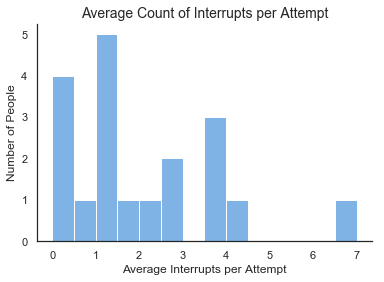

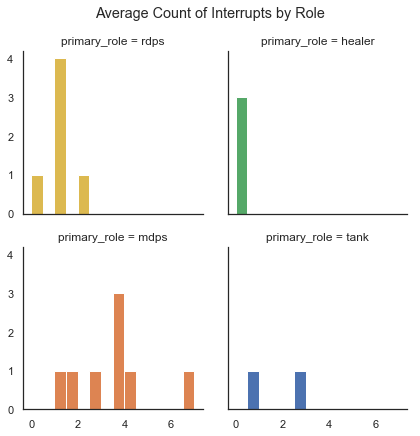

Mean is 2.080432 per attempt.
Median is 1.470085 per attempt.
Max attempts by player is 118.


In [185]:
la.collect_stats(data=interrupts, master_list=master_list, player_list=player_list, 
                 boss_name="Zek'voz", boss_id=2136, spell_name='Interrupts', 
                 analysis_columns=['count'], min_attempts=10, least=False, bins=bins)

### Healing Done to Tanks

In [74]:
print(healers, tanks)

8         Illestra
14    Katanescence
17        Mythrose
19         Acturus
21         Jampers
26      Velsummers
Name: player, dtype: object 7      Earrl
12    Draigo
Name: player, dtype: object


In [76]:
df_list = []
healers = list(player_list.query('primary_role == "healer"')['player'])
tanks = list(player_list.query('primary_role =="tank"')['player'])
logs = wl.get_log_ids(master_list, 2136)
for log in logs:
    print('Collecting details for log', log)

    # Complete query
    link = wl.create_link(api_key, 'healing', master_list, log, boss_id=2136)
    details = wl.get_query_details(link)
    
    # Get healer info
    for player in details['entries']:
        name = player['name']
        if name in healers:
            print('Player added:', name)
            healing = 0
            for target in player['targets']:
                if target['name'] in tanks:
                    healing += target['total']
            df_list.append({
                'log_id': log,
                'player': name,
                'healing_done': healing
            })

healing_df = pd.DataFrame(df_list, columns=['log_id', 'player', 'healing_done'])

Player added: Katanescence
Player added: Mythrose
Player added: Illestra
Player added: Acturus
Player added: Acturus
Player added: Jampers
Player added: Illestra
Player added: Katanescence
Player added: Jampers
Player added: Katanescence
Player added: Illestra
Player added: Acturus
Player added: Acturus
Player added: Mythrose
Player added: Illestra
Player added: Katanescence
Player added: Illestra
Player added: Mythrose
Player added: Katanescence
Player added: Acturus
Player added: Katanescence
Player added: Acturus
Player added: Mythrose
Player added: Illestra
Player added: Illestra
Player added: Katanescence
Player added: Acturus
Player added: Jampers
Player added: Mythrose
Player added: Illestra
Player added: Jampers
Player added: Acturus
Player added: Mythrose
Player added: Jampers
Player added: Mythrose
Player added: Acturus
Player added: Illestra
Player added: Mythrose
Player added: Acturus
Player added: Jampers
Player added: Katanescence
Player added: Illestra
Player added: Actu

In [77]:
healing_df.head()

,log_id,player,healing_done
0,4zpRXjQA3Fhg9KdJ,Katanescence,20205076
1,4zpRXjQA3Fhg9KdJ,Mythrose,32718124
2,4zpRXjQA3Fhg9KdJ,Illestra,26479207
3,4zpRXjQA3Fhg9KdJ,Acturus,39387207
4,ArqaVzbYtW7BG2Cx,Acturus,2235723


In [78]:
bins = None

         player  healing_done  fight_count primary_role      av_count
0       Acturus     164356752          117       healer  1.404759e+06
4      Mythrose     141931531          106       healer  1.338977e+06
1      Illestra     121670736          117       healer  1.039921e+06
3  Katanescence      56631485           75       healer  7.550865e+05
2       Jampers      50712681           75       healer  6.761691e+05


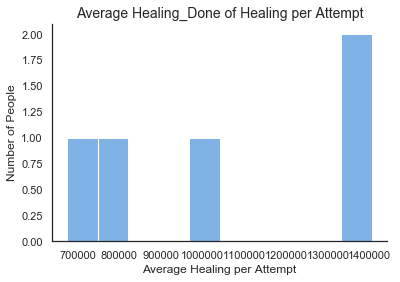

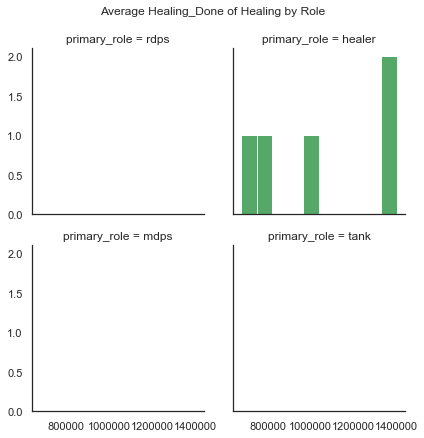

Mean is 1042982.327766 per attempt.
Median is 1039920.820513 per attempt.
Max attempts by player is 117.


In [79]:
la.collect_stats(data=healing_df, master_list=master_list, player_list=player_list, 
                 boss_name="Zek'voz", boss_id=2136, spell_name='Healing', 
                 analysis_columns=['healing_done'], min_attempts=10, least=False, bins=bins)

<a id='vectis'></a>
## Vectis

### Most Plague Bomb Soaks
ID: 266948

In [125]:
importlib.reload(wl)

<module 'warcraft_logs_fn' from 'C:\\Users\\rebecca-barnes\\Git-Hub-Repos\\wow-analysis\\warcraft_logs_fn.py'>

In [126]:
soaks = wl.buff_duration(api_key, master_list, 266948, boss_id=2134, buff=False)

Player added: Uuglei
Player added: Shadowbaine
Player added: Grombrindal
Player added: Petrol
Player added: Vaelyra
Player added: Tawn
Player added: Brian
Player added: Kiwisoda
Player added: Velryssa
Player added: Ayriea
Player added: Katanescence
Player added: Draigo
Player added: Earrl
Player added: Vampyric
Player added: Stradlock
Player added: Metonymy
Player added: Mythrose
Player added: Liavre
Player added: Katanescence
Player added: Toy
Player added: Tawn
Player added: Metonymy
Player added: Draigo
Player added: Vampyric
Player added: Earrl
Player added: Uuglei
Player added: Shadowbaine
Player added: Ayriea
Player added: Stradlock
Player added: Psychodruid
Player added: Acturus
Player added: Velryssa
Player added: Vaelyra
Player added: Petrol
Player added: Kiwisoda
Player added: Illestra
Player added: Toy
Player added: Metonymy
Player added: Velryssa
Player added: Uuglei
Player added: Acturus
Player added: Liavre
Player added: Ayriea
Player added: Katanescence
Player added: Jam

In [127]:
soaks.head()

,log_id,spell_id,player,duration,uses
0,ArqaVzbYtW7BG2Cx,266948,Uuglei,48039,6
1,ArqaVzbYtW7BG2Cx,266948,Shadowbaine,58063,8
2,ArqaVzbYtW7BG2Cx,266948,Grombrindal,64030,8
3,ArqaVzbYtW7BG2Cx,266948,Petrol,98179,13
4,ArqaVzbYtW7BG2Cx,266948,Vaelyra,64056,8


In [182]:
bins = np.arange(0.25, 2.5, 0.25)

          player  uses  fight_count primary_role  av_count
2          Brian   171           85         mdps  2.011765
23      Vampyric   180           90         mdps  2.000000
11        Liavre    86           47         mdps  1.829787
3         Draigo   160           90         tank  1.777778
17     Stradlock   121           70         rdps  1.728571
22       Vaelyra   127           79         mdps  1.607595
1         Ayriea   126           88         rdps  1.431818
18          Sumi   112           79         rdps  1.417722
12      Metonymy   126           90         rdps  1.400000
5    Grombrindal   118           85         mdps  1.388235
14        Petrol   120           90         rdps  1.333333
4          Earrl   119           90         tank  1.322222
19          Tawn    52           43         rdps  1.209302
16   Shadowbaine    65           55         rdps  1.181818
21        Uuglei    88           79         mdps  1.113924
20           Toy    94           90         mdps  1.0444

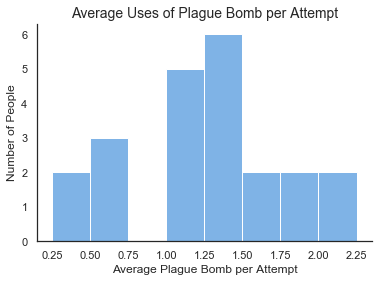

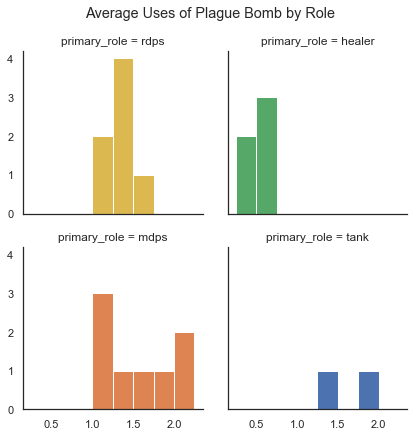

Mean is 1.241666 per attempt.
Median is 1.327778 per attempt.
Max attempts by player is 90.


In [183]:
la.collect_stats(data=soaks, master_list=master_list, player_list=player_list, 
                 boss_name="Vectis", boss_id=2134, spell_name='Plague Bomb', 
                 analysis_columns=['uses'], min_attempts=40, least=False, bins=bins)

### Lingering Infection
ID: 265127

In [132]:
infection = wl.buff_duration(api_key, master_list, 265127, boss_id=2134, buff=False)

Player added: Petrol
Player added: Vaelyra
Player added: Earrl
Player added: Illestra
Player added: Metonymy
Player added: Ayriea
Player added: Acturus
Player added: Tawn
Player added: Draigo
Player added: Jampers
Player added: Vampyric
Player added: Uuglei
Player added: Stradlock
Player added: Kiwisoda
Player added: Velryssa
Player added: Toy
Player added: Brian
Player added: Shadowbaine
Player added: Grombrindal
Player added: Katanescence
Player added: Earrl
Player added: Jampers
Player added: Acturus
Player added: Uuglei
Player added: Petrol
Player added: Draigo
Player added: Toy
Player added: Vaelyra
Player added: Shadowbaine
Player added: Ayriea
Player added: Psychodruid
Player added: Vampyric
Player added: Kiwisoda
Player added: Illestra
Player added: Stradlock
Player added: Velryssa
Player added: Katanescence
Player added: Tawn
Player added: Mythrose
Player added: Metonymy
Player added: Liavre
Player added: Sumi
Player added: Illestra
Player added: Toy
Player added: Metonymy
Pla

In [133]:
infection.head()

,log_id,spell_id,player,duration,uses
0,ArqaVzbYtW7BG2Cx,265127,Petrol,1183370,37
1,ArqaVzbYtW7BG2Cx,265127,Vaelyra,1143300,40
2,ArqaVzbYtW7BG2Cx,265127,Earrl,1114100,21
3,ArqaVzbYtW7BG2Cx,265127,Illestra,860527,46
4,ArqaVzbYtW7BG2Cx,265127,Metonymy,1043368,32


In [180]:
bins = np.arange(3, 7.5, 0.5)

          player  uses  fight_count primary_role  av_count
4          Earrl   305           90         tank  3.388889
3         Draigo   360           90         tank  4.000000
5    Grombrindal   353           85         mdps  4.152941
2          Brian   357           85         mdps  4.200000
22       Vaelyra   351           79         mdps  4.443038
14        Petrol   422           90         rdps  4.688889
12      Metonymy   423           90         rdps  4.700000
23      Vampyric   426           90         mdps  4.733333
24      Velryssa   334           70         mdps  4.771429
11        Liavre   226           47         mdps  4.808511
16   Shadowbaine   265           55         rdps  4.818182
1         Ayriea   435           88         rdps  4.943182
17     Stradlock   354           70         rdps  5.057143
18          Sumi   416           79         rdps  5.265823
19          Tawn   234           43         rdps  5.441860
21        Uuglei   491           79         mdps  6.2151

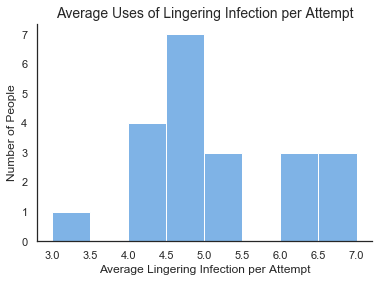

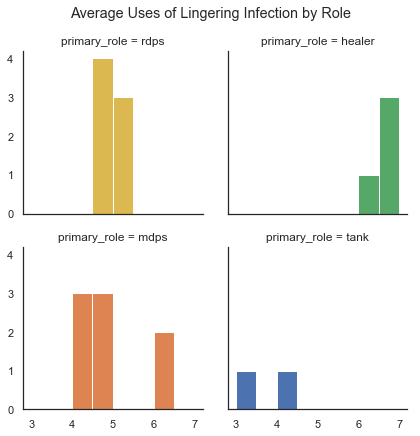

Mean is 5.258070 per attempt.
Median is 4.880682 per attempt.
Max attempts by player is 90.


In [181]:
la.collect_stats(data=infection, master_list=master_list, player_list=player_list, 
                 boss_name="Vectis", boss_id=2134, spell_name='Lingering Infection', 
                 analysis_columns=['uses'], min_attempts=40, bins=bins)

<a id='fetid'></a>
## Fetid

### Debuff Stacks
IDs:
- Malodorous Miasma: 262313
- Putrid Paroxysm: 262314

In [138]:
miasma = wl.buff_duration(api_key, master_list, 262313, 
                          spell_name='Malodorous Miasma', boss_id=2128, buff=False)

Player added: Illestra
Player added: Toy
Player added: Shadowbaine
Player added: Stradlock
Player added: Liavre
Player added: Acturus
Player added: Sumi
Player added: Tawn
Player added: Ayriea
Player added: Vaelyra
Player added: Petrol
Player added: Kiwisoda
Player added: Metonymy
Player added: Earrl
Player added: Draigo
Player added: Vampyric
Player added: Velryssa
Player added: Kopyelock
Player added: Katanescence
Player added: Jampers
Player added: Earrl
Player added: Ayriea
Player added: Shadowbaine
Player added: Grombrindal
Player added: Mythrose
Player added: Jampers
Player added: Toy
Player added: Petrol
Player added: Vampyric
Player added: Draigo
Player added: Brian
Player added: Sumi
Player added: Metonymy
Player added: Vaelyra
Player added: Kopyelock
Player added: Tawn
Player added: Psychodruid
Player added: Katanescence
Player added: Stradlock
Player added: Acturus
Player added: Jampers
Player added: Velryssa
Player added: Toy
Player added: Shadowbaine
Player added: Kiwisoda

In [139]:
parox = wl.buff_duration(api_key, master_list, 262314, 
                          spell_name='Putrid Paroxysm', boss_id=2128, buff=False)

Player added: Vaelyra
Player added: Acturus
Player added: Katanescence
Player added: Toy
Player added: Jampers
Player added: Ayriea
Player added: Vampyric
Player added: Velryssa
Player added: Stradlock
Player added: Earrl
Player added: Metonymy
Player added: Kopyelock
Player added: Draigo
Player added: Kiwisoda
Player added: Sumi
Player added: Liavre
Player added: Shadowbaine
Player added: Illestra
Player added: Tawn
Player added: Petrol
Player added: Acturus
Player added: Tawn
Player added: Vaelyra
Player added: Brian
Player added: Metonymy
Player added: Katanescence
Player added: Shadowbaine
Player added: Draigo
Player added: Jampers
Player added: Ayriea
Player added: Sumi
Player added: Stradlock
Player added: Grombrindal
Player added: Psychodruid
Player added: Kopyelock
Player added: Toy
Player added: Mythrose
Player added: Petrol
Player added: Earrl
Player added: Vampyric
Player added: Liavre
Player added: Toy
Player added: Tawn
Player added: Velryssa
Player added: Petrol
Player ad

In [159]:
debuffs = pd.concat([miasma, parox])
debuffs.head()

,log_id,spell_id,spell_name,player,duration,uses
0,6JMd2cmzFk8Qa1gj,262313,Malodorous Miasma,Illestra,440386,40
1,6JMd2cmzFk8Qa1gj,262313,Malodorous Miasma,Toy,433575,37
2,6JMd2cmzFk8Qa1gj,262313,Malodorous Miasma,Shadowbaine,347459,30
3,6JMd2cmzFk8Qa1gj,262313,Malodorous Miasma,Stradlock,417209,26
4,6JMd2cmzFk8Qa1gj,262313,Malodorous Miasma,Liavre,538364,45


In [199]:
bins = np.arange(5, 11.5, 0.5)

          player  uses  fight_count primary_role   av_count
4          Earrl   520          102         tank   5.098039
3         Draigo   559          102         tank   5.480392
14        Petrol   676          102         rdps   6.627451
15   Psychodruid   545           76         rdps   7.171053
12      Metonymy   734          102         rdps   7.196078
6       Illestra   329           44       healer   7.477273
19          Tawn   735           98         rdps   7.500000
0        Acturus   792          102       healer   7.764706
16   Shadowbaine   779          100         rdps   7.790000
10     Kopyelock   604           77         rdps   7.844156
22       Vaelyra   806          102         mdps   7.901961
17     Stradlock   810          101         rdps   8.019802
13      Mythrose   502           62       healer   8.096774
23      Vampyric   860          102         mdps   8.431373
18          Sumi   872          102         rdps   8.549020
20           Toy   841           98     

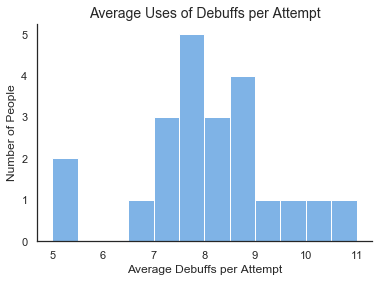

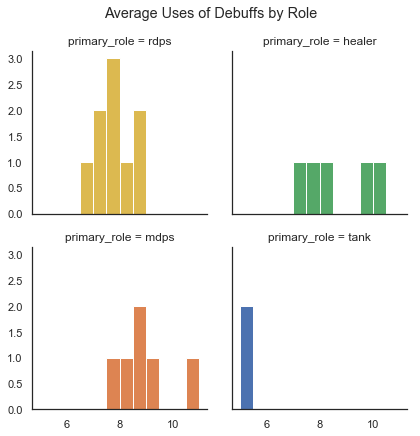

Mean is 8.050968 per attempt.
Median is 7.960881 per attempt.
Max attempts by player is 102.


In [200]:
la.collect_stats(data=debuffs, master_list=master_list, player_list=player_list, 
                 boss_name="Fetid", boss_id=2128, spell_name='Debuffs', 
                 analysis_columns=['uses'], min_attempts=40, bins=bins)

### Add Damage

In [203]:
adds = wl.damage_done(api_key, master_list, boss_id=2128)

Player added: Petrol
Player added: Stradlock
Player added: Toy
Player added: Katanescence
Player added: Vaelyra
Player added: Velryssa
Player added: Sumi
Player added: Kopyelock
Player added: Jampers
Player added: Draigo
Player added: Ayriea
Player added: Kiwisoda
Player added: Vampyric
Player added: Liavre
Player added: Illestra
Player added: Shadowbaine
Player added: Acturus
Player added: Metonymy
Player added: Tawn
Player added: Earrl
Player added: Earrl
Player added: Acturus
Player added: Ayriea
Player added: Kopyelock
Player added: Vampyric
Player added: Tawn
Player added: Brian
Player added: Petrol
Player added: Jampers
Player added: Metonymy
Player added: Draigo
Player added: Psychodruid
Player added: Shadowbaine
Player added: Stradlock
Player added: Katanescence
Player added: Mythrose
Player added: Toy
Player added: Sumi
Player added: Vaelyra
Player added: Grombrindal
Player added: Tawn
Player added: Petrol
Player added: Metonymy
Player added: Shadowbaine
Player added: Velryssa

In [204]:
adds.head()

,log_id,player,NPC,damage_done
0,6JMd2cmzFk8Qa1gj,Petrol,True,4618966
1,6JMd2cmzFk8Qa1gj,Stradlock,True,6591115
2,6JMd2cmzFk8Qa1gj,Toy,True,5544719
3,6JMd2cmzFk8Qa1gj,Katanescence,True,30875
4,6JMd2cmzFk8Qa1gj,Vaelyra,True,6062353


In [208]:
bins = np.arange(0, 900000, 100000)

          player  damage_done  fight_count primary_role       av_count
17     Stradlock     80373848          101         rdps  795780.673267
10     Kopyelock     60592756           77         rdps  786918.909091
20           Toy     65576811           98         mdps  669151.132653
19          Tawn     62999867           98         rdps  642855.785714
22       Vaelyra     65416346          102         mdps  641336.725490
15   Psychodruid     48659909           76         rdps  640261.960526
11        Liavre     31563191           53         mdps  595531.905660
23      Vampyric     60605018          102         mdps  594166.843137
2          Brian     43572922           76         mdps  573327.921053
14        Petrol     57573060          102         rdps  564441.764706
5    Grombrindal     36501868           72         mdps  506970.388889
12      Metonymy     51460114          102         rdps  504510.921569
16   Shadowbaine     38535802          100         rdps  385358.020000
1     

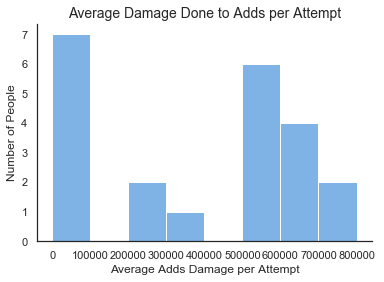

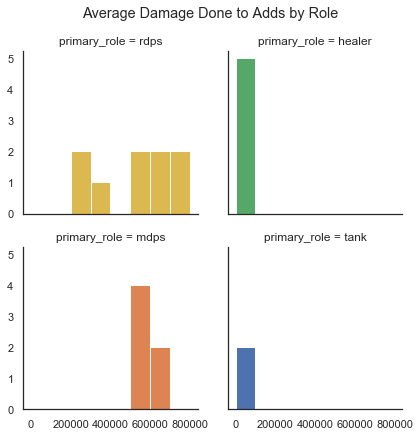

Mean is 392674.473466 per attempt.
Median is 505740.655229 per attempt.
Max attempts by player is 102.


In [214]:
la.collect_stats(data=adds, master_list=master_list, player_list=player_list, 
                 boss_name="Fetid", boss_id=2128, spell_name='Adds', 
                 analysis_columns=['damage_done'], min_attempts=40, bins=bins, 
                 least=False)

<a id='zul' ></a>
## Zul

### High Boss, Low Add Damage

In [215]:
zul_boss = wl.damage_done(api_key, master_list, boss_id=2145, NPC=False)

Player added: Tawn
Player added: Noraela
Player added: Jampers
Player added: Brassi
Player added: Stradlock
Player added: Illestra
Player added: Animated Ichor
Player added: Katheals
Player added: Shadowbaine
Player added: Earrl
Player added: Liavre
Player added: Draigo
Player added: Velryssa
Player added: Invinceble
Player added: Acturus
Player added: Petrol
Player added: Metonymy
Player added: Toy
Player added: Kiwisoda
Player added: Kopyelock
Player added: Brian
Player added: Earrl
Player added: Brian
Player added: Grombrindal
Player added: Jampers
Player added: Metonymy
Player added: Toy
Player added: Kopyelock
Player added: Noraela
Player added: Animated Ichor
Player added: Kiwisoda
Player added: Draigo
Player added: Stradlock
Player added: Tawn
Player added: Invinceble
Player added: Illestra
Player added: Petrol
Player added: Velryssa
Player added: Brassi
Player added: Shadowbaine
Player added: Acturus
Player added: Jampers
Player added: Earrl
Player added: Petrol
Player added: M

In [216]:
zul_boss.head()

,log_id,player,NPC,damage_done
0,6JMd2cmzFk8Qa1gj,Tawn,False,4261525
1,6JMd2cmzFk8Qa1gj,Noraela,False,15278866
2,6JMd2cmzFk8Qa1gj,Jampers,False,31342
3,6JMd2cmzFk8Qa1gj,Brassi,False,13708969
4,6JMd2cmzFk8Qa1gj,Stradlock,False,7531744


In [238]:
bins = np.arange(0, 5e6, 5e5)

         player  damage_done  fight_count primary_role      av_count
3         Brian    211897485         48.0         mdps  4.414531e+06
12       Liavre     67415018         16.0         mdps  4.213439e+06
22      Vaelyra    153925287         48.0         mdps  3.206777e+06
2        Ayriea    149346905         48.0         rdps  3.111394e+06
18         Sumi    146329691         48.0         rdps  3.048535e+06
13     Metonymy     88031445         48.0         rdps  1.833988e+06
17    Stradlock     86358328         48.0         rdps  1.799132e+06
11    Kopyelock     66296395         38.0         rdps  1.744642e+06
15       Petrol     80862003         48.0         rdps  1.684625e+06
6   Grombrindal     70545372         42.0         mdps  1.679652e+06
16  Shadowbaine     78954936         48.0         rdps  1.644894e+06
23     Velryssa     70589035         48.0         mdps  1.470605e+06
21       Uuglei     10952907         10.0         mdps  1.095291e+06
19         Tawn     49007653      

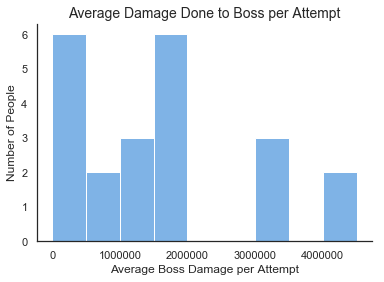

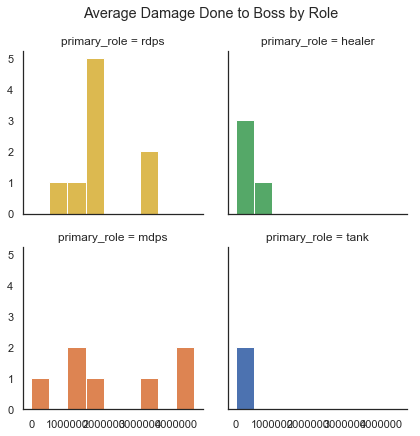

Mean is 1587555.401884 per attempt.
Median is 1557749.697917 per attempt.
Max attempts by player is 48.0.


In [239]:
la.collect_stats(data=zul_boss, master_list=master_list, player_list=player_list, 
                 boss_name="Zul", boss_id=2145, spell_name='Boss', 
                 analysis_columns=['damage_done'], min_attempts=10, bins=bins, 
                 least=False)

In [240]:
zul_adds = wl.damage_done(api_key, master_list, boss_id=2145, NPC=True)

Player added: Tawn
Player added: Noraela
Player added: Jampers
Player added: Brassi
Player added: Stradlock
Player added: Illestra
Player added: Animated Ichor
Player added: Katheals
Player added: Shadowbaine
Player added: Earrl
Player added: Liavre
Player added: Draigo
Player added: Velryssa
Player added: Invinceble
Player added: Acturus
Player added: Petrol
Player added: Metonymy
Player added: Toy
Player added: Kiwisoda
Player added: Kopyelock
Player added: Brian
Player added: Earrl
Player added: Brian
Player added: Grombrindal
Player added: Jampers
Player added: Metonymy
Player added: Toy
Player added: Kopyelock
Player added: Noraela
Player added: Animated Ichor
Player added: Kiwisoda
Player added: Draigo
Player added: Stradlock
Player added: Tawn
Player added: Invinceble
Player added: Illestra
Player added: Petrol
Player added: Velryssa
Player added: Brassi
Player added: Shadowbaine
Player added: Acturus
Player added: Jampers
Player added: Earrl
Player added: Petrol
Player added: M

In [245]:
bins = np.arange(0, 2.5e6, 2.5e5)

         player  damage_done  fight_count primary_role      av_count
7      Illestra        81448         48.0       healer  1.696833e+03
8       Jampers       544587         48.0       healer  1.134556e+04
14     Mythrose       613716         42.0       healer  1.461229e+04
0       Acturus      2276403         48.0       healer  4.742506e+04
10     Kiwisoda      8395687         38.0         rdps  2.209391e+05
20          Toy     23974930         48.0         mdps  4.994777e+05
13     Metonymy     29825350         48.0         rdps  6.213615e+05
15       Petrol     32546521         48.0         rdps  6.780525e+05
5         Earrl     40631849         48.0         tank  8.464969e+05
21       Uuglei     10169059         10.0         mdps  1.016906e+06
22      Vaelyra     50549300         48.0         mdps  1.053110e+06
11    Kopyelock     45598398         38.0         rdps  1.199958e+06
2        Ayriea     59061324         48.0         rdps  1.230444e+06
18         Sumi     61443146      

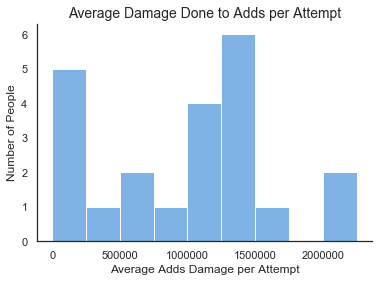

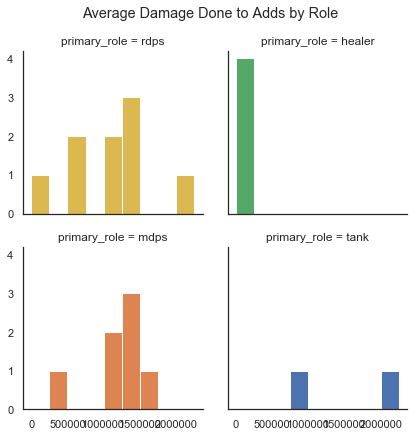

Mean is 969441.753187 per attempt.
Median is 1126534.129386 per attempt.
Max attempts by player is 48.0.


In [246]:
la.collect_stats(data=zul_adds, master_list=master_list, player_list=player_list, 
                 boss_name="Zul", boss_id=2145, spell_name='Adds', 
                 analysis_columns=['damage_done'], min_attempts=10, bins=bins)

### Dispells
Spell IDs:
- Priest: Purify (527), Mass Dispel (32375)
- Paladin: Cleanse (4987)
- Shaman: Purify Spirit (77130)

In [247]:
dispell_ids = [527, 32375, 4987, 77130]

In [250]:
dispells = pd.DataFrame([], columns=['log_id', 'spell_id', 'player', 'count'])

for dispell_id in dispell_ids:
    dispell = wl.cast_count(api_key, master_list, dispell_id, boss_id=2145)
    dispells = pd.concat([dispells, dispell])

Player added: Jampers
Player added: Jampers
Player added: Mythrose
Player added: Jampers
Player added: Jampers
Player added: Mythrose
Player added: Jampers
Player added: Jampers
Player added: Katheals
Player added: Jampers
Player added: Mythrose
Player added: Jampers
Player added: Katheals
Player added: Jampers
Player added: Jampers
Player added: Acturus
Player added: Illestra
Player added: Illestra
Player added: Illestra
Player added: Illestra


In [251]:
dispells.head()

,log_id,spell_id,player,count
0,6JMd2cmzFk8Qa1gj,527,Jampers,4
1,81HkLmCMRdAg6rNJ,527,Jampers,19
2,81HkLmCMRdAg6rNJ,527,Mythrose,1
3,d3P97v4DpLHmyZkW,527,Jampers,4
4,nxf6krQP8Bvty9V2,527,Jampers,7


In [252]:
bins = None

     player  count  fight_count primary_role  av_count
2   Jampers    122           48       healer  2.541667
1  Illestra     23           48       healer  0.479167
4  Mythrose      4           42       healer  0.095238
0   Acturus      3           48       healer  0.062500


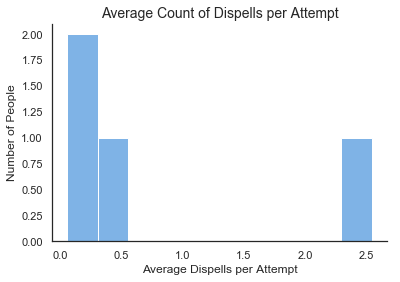

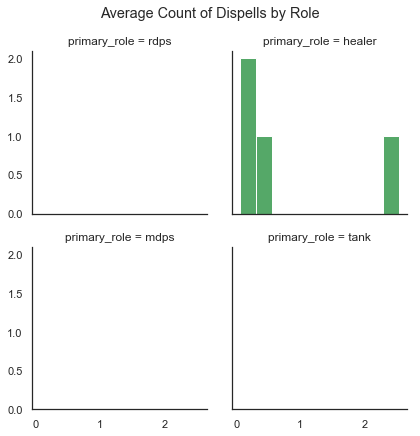

Mean is 0.794643 per attempt.
Median is 0.287202 per attempt.
Max attempts by player is 48.


In [254]:
la.collect_stats(data=dispells, master_list=master_list, player_list=player_list, 
                 boss_name="Zul", boss_id=2145, spell_name='Dispells', 
                 analysis_columns=['count'], min_attempts=10, bins=bins, least=False)

<a id='mythrax'></a>
## Mythrax

### Obliteration Blast 
ID: 273554

In [255]:
blast = wl.damage_taken(api_key, master_list, 273554, boss_id=2135)

Player added: Liavre
Player added: Petrol
Player added: Metonymy
Player added: Psychodruid
Player added: Sumi
Player added: Acturus
Player added: Mythrose
Player added: Vaelyra
Player added: Draigo
Player added: Ayriea
Player added: Tawn
Player added: Illestra
Player added: Toy
Player added: Grombrindal
Player added: Kopyelock
Player added: Brian
Player added: Shadowbaine
Player added: Earrl
Player added: Jampers
Player added: Katanescence
Player added: Katanescence
Player added: Draigo
Player added: Ayriea
Player added: Acturus
Player added: Kiwisoda
Player added: Tawn
Player added: Vampyric
Player added: Brian
Player added: Metonymy
Player added: Kopyelock
Player added: Grombrindal
Player added: Sumi
Player added: Earrl
Player added: Petrol
Player added: Uuglei
Player added: Jampers
Player added: Psychodruid
Player added: Mythrose
Player added: Shadowbaine
Player added: Illestra
Player added: Sumi
Player added: Vaelyra
Player added: Draigo
Player added: Petrol
Player added: Tawn
Play

In [256]:
blast.head()

,log_id,spell_id,player,hits,damage_taken
0,1rnktHXvcTWD2JzL,273554,Liavre,28,2212411
1,1rnktHXvcTWD2JzL,273554,Petrol,4,314570
2,1rnktHXvcTWD2JzL,273554,Metonymy,14,1016521
3,1rnktHXvcTWD2JzL,273554,Psychodruid,3,225986
4,1rnktHXvcTWD2JzL,273554,Sumi,7,548745


In [267]:
bins = np.arange(0.1, 1.4, 0.1)

          player  hits  fight_count primary_role  av_count
1         Ayriea    13           73         rdps  0.178082
2          Brian    26          104         mdps  0.250000
15   Psychodruid    27          105         rdps  0.257143
7        Jampers    30          105       healer  0.285714
6       Illestra    32          105       healer  0.304762
10     Kopyelock    32          105         rdps  0.304762
23      Vampyric    15           48         mdps  0.312500
4          Earrl    34          105         tank  0.323810
14        Petrol    35          105         rdps  0.333333
0        Acturus    36          105       healer  0.342857
19          Tawn    38          105         rdps  0.361905
9       Kiwisoda    32           88         rdps  0.363636
18          Sumi    39          105         rdps  0.371429
16   Shadowbaine    33           87         rdps  0.379310
17     Stradlock    17           44         rdps  0.386364
13      Mythrose    33           75       healer  0.4400

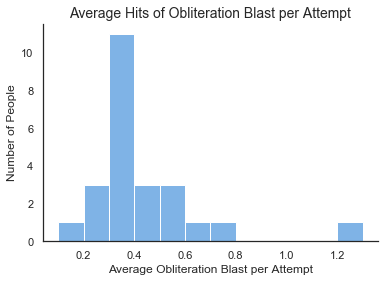

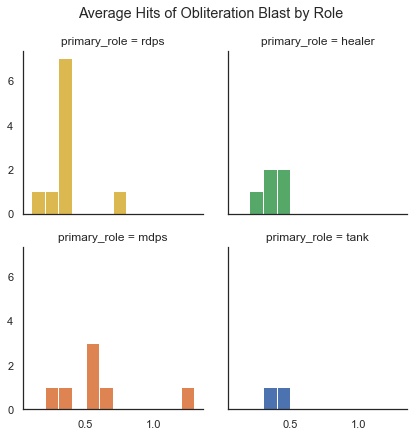

Mean is 0.433732 per attempt.
Median is 0.367532 per attempt.
Max attempts by player is 105.


In [268]:
la.collect_stats(data=blast, master_list=master_list, player_list=player_list, 
                 boss_name="Mythrax", boss_id=2135, spell_name='Obliteration Blast', 
                 analysis_columns=['hits'], min_attempts=10, bins=bins)

### Annihilation
ID: 272146

In [269]:
annihilation = wl.buff_duration(api_key, master_list, 272146, 
                                boss_id=2135, buff=False)

Player added: Ayriea
Player added: Illestra
Player added: Kopyelock
Player added: Liavre
Player added: Petrol
Player added: Metonymy
Player added: Psychodruid
Player added: Jampers
Player added: Draigo
Player added: Mythrose
Player added: Katanescence
Player added: Grombrindal
Player added: Shadowbaine
Player added: Toy
Player added: Tawn
Player added: Vaelyra
Player added: Sumi
Player added: Brian
Player added: Earrl
Player added: Acturus
Player added: Petrol
Player added: Jampers
Player added: Uuglei
Player added: Illestra
Player added: Psychodruid
Player added: Draigo
Player added: Metonymy
Player added: Vampyric
Player added: Earrl
Player added: Katanescence
Player added: Kopyelock
Player added: Sumi
Player added: Mythrose
Player added: Kiwisoda
Player added: Tawn
Player added: Brian
Player added: Acturus
Player added: Ayriea
Player added: Shadowbaine
Player added: Grombrindal
Player added: Stradlock
Player added: Toy
Player added: Vaelyra
Player added: Earrl
Player added: Kopyeloc

In [271]:
annihilation.head()

,log_id,spell_id,player,duration,uses
0,1rnktHXvcTWD2JzL,272146,Ayriea,2260995,264
1,1rnktHXvcTWD2JzL,272146,Illestra,2211708,325
2,1rnktHXvcTWD2JzL,272146,Kopyelock,3284356,259
3,1rnktHXvcTWD2JzL,272146,Liavre,3257892,514
4,1rnktHXvcTWD2JzL,272146,Petrol,2551535,306


In [274]:
bins = np.arange(10, 19, 1)

          player  uses  fight_count primary_role   av_count
9       Kiwisoda   892           88         rdps  10.136364
15   Psychodruid  1174          105         rdps  11.180952
10     Kopyelock  1237          105         rdps  11.780952
14        Petrol  1280          105         rdps  12.190476
1         Ayriea   898           73         rdps  12.301370
19          Tawn  1308          105         rdps  12.457143
18          Sumi  1366          105         rdps  13.009524
16   Shadowbaine  1140           87         rdps  13.103448
6       Illestra  1391          105       healer  13.247619
0        Acturus  1473          105       healer  14.028571
7        Jampers  1530          105       healer  14.571429
22       Vaelyra  1121           75         mdps  14.946667
5    Grombrindal  1507           97         mdps  15.536082
12      Metonymy  1694          105         rdps  16.133333
8   Katanescence  1702          105       healer  16.209524
2          Brian  1750          104     

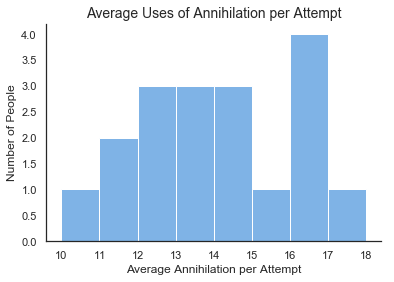

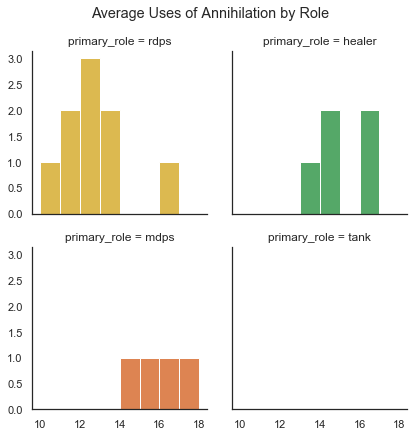

Mean is 20.745724 per attempt.
Median is 14.300000 per attempt.
Max attempts by player is 105.


In [275]:
la.collect_stats(data=annihilation, master_list=master_list, player_list=player_list, 
                 boss_name="Mythrax", boss_id=2135, spell_name='Annihilation', 
                 analysis_columns=['uses'], min_attempts=50, bins=bins)

<a id='ghuun'></a>
## G'Huun

### Gaze of G'Huun
ID: 267700

In [3]:
fears = wl.buff_duration(api_key, master_list, 267700, boss_id=2122, buff=False)

Player added: Velsummers
Player added: Illestra
Player added: Velryssa
Player added: Metonymy
Player added: Acturus
Player added: Petrol
Player added: Grombrindal
Player added: Jampers
Player added: Uuglei
Player added: Stradlock
Player added: Jampers
Player added: Illestra
Player added: Psychodruid
Player added: Tawn
Player added: Acturus
Player added: Mythrose
Player added: Draigo
Player added: Velryssa
Player added: Petrol
Player added: Earrl
Player added: Jampers
Player added: Velryssa
Player added: Velsummers
Player added: Draigo
Player added: Illestra
Player added: Vampyric
Player added: Toy
Player added: Grombrindal
Player added: Psychodruid
Player added: Shadowbaine
Player added: Metonymy
Player added: Vaelyra
Player added: Acturus
Player added: Tawn
Player added: Toy
Player added: Psychodruid
Player added: Kopyelock
Player added: Grombrindal
Player added: Vampyric
Player added: Toy
Player added: Petrol
Player added: Grombrindal
Player added: Draigo
Player added: Earrl
Player a

In [4]:
fears.head()

,log_id,spell_id,player,duration,uses
0,GbryNmfD98zcH6Jn,267700,Velsummers,2809,1
1,GbryNmfD98zcH6Jn,267700,Illestra,5818,1
2,GbryNmfD98zcH6Jn,267700,Velryssa,890,1
3,GbryNmfD98zcH6Jn,267700,Metonymy,2618,3
4,GbryNmfD98zcH6Jn,267700,Acturus,2277,1


In [9]:
bins = np.arange(0, 0.08, 0.01)

         player  uses  fight_count primary_role  av_count
1        Ayriea     1          296         rdps  0.003378
2         Brian     2          296         mdps  0.006757
13  Shadowbaine     3          291         rdps  0.010309
14    Stradlock     4          225         rdps  0.017778
19     Vampyric     4          224         mdps  0.017857
3        Draigo     7          296         tank  0.023649
8     Kopyelock     7          295         rdps  0.023729
10     Mythrose     7          289       healer  0.024221
21   Velsummers     7          271       healer  0.025830
0       Acturus     7          258       healer  0.027132
7       Jampers     8          293       healer  0.027304
11       Petrol     9          296         rdps  0.030405
12  Psychodruid     9          293         rdps  0.030717
16          Toy     8          244         mdps  0.032787
18      Vaelyra     7          184         mdps  0.038043
6      Illestra    12          295       healer  0.040678
4         Earr

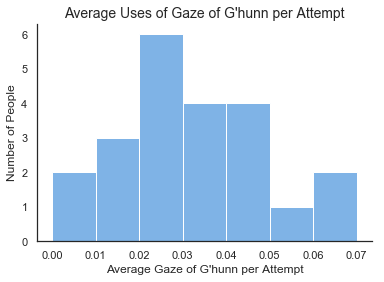

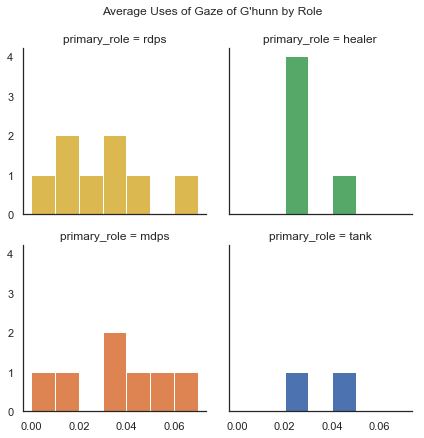

Mean is 0.031568 per attempt.
Median is 0.028855 per attempt.
Max attempts by player is 296.


In [10]:
la.collect_stats(data=fears, master_list=master_list, player_list=player_list, 
                 boss_name="G'huun", boss_id=2122, spell_name="Gaze of G'hunn", 
                 analysis_columns=['uses'], min_attempts=10, bins=bins)

### Virulent Corruption
ID: 273486

In [35]:
orbs = wl.damage_taken(api_key, master_list, 273486, boss_id=2122,  
                       hit_type='hitCount', death_cutoff=10)

Player added: Vaelyra
Player added: Metonymy
Player added: Earrl
Player added: Petrol
Player added: Stradlock
Player added: Brian
Player added: Illestra
Player added: Tawn
Player added: Ayriea
Player added: Grombrindal
Player added: Shadowbaine
Player added: Acturus
Player added: Velsummers
Player added: Mythrose
Player added: Kopyelock
Player added: Toy
Player added: Vampyric
Player added: Velryssa
Player added: Psychodruid
Player added: Jampers
Player added: Draigo
Player added: Petrol
Player added: Brian
Player added: Vampyric
Player added: Mythrose
Player added: Metonymy
Player added: Velsummers
Player added: Acturus
Player added: Kopyelock
Player added: Uuglei
Player added: Grombrindal
Player added: Shadowbaine
Player added: Ayriea
Player added: Draigo
Player added: Stradlock
Player added: Psychodruid
Player added: Velryssa
Player added: Illestra
Player added: Tawn
Player added: Jampers
Player added: Earrl
Player added: Tawn
Player added: Jampers
Player added: Grombrindal
Player a

In [36]:
orbs.head()

,log_id,spell_id,player,hits,damage_taken
0,9t1JjYfvbZkyWCGP,273486,Vaelyra,10,415943
1,9t1JjYfvbZkyWCGP,273486,Metonymy,4,183209
2,9t1JjYfvbZkyWCGP,273486,Earrl,9,245969
3,9t1JjYfvbZkyWCGP,273486,Petrol,5,212317
4,9t1JjYfvbZkyWCGP,273486,Stradlock,8,374656


In [44]:
bins = np.arange(0.1, 0.8, 0.1)

         player  hits  fight_count primary_role  av_count
7       Jampers    52          293       healer  0.177474
11       Petrol    53          296         rdps  0.179054
6      Illestra    56          295       healer  0.189831
8     Kopyelock    63          295         rdps  0.213559
1        Ayriea    78          296         rdps  0.263514
15         Tawn    79          285         rdps  0.277193
5   Grombrindal    85          296         mdps  0.287162
21   Velsummers    79          271       healer  0.291513
10     Mythrose    86          289       healer  0.297578
20     Velryssa    89          292         mdps  0.304795
13  Shadowbaine    96          291         rdps  0.329897
19     Vampyric    75          224         mdps  0.334821
9      Metonymy    99          295         rdps  0.335593
18      Vaelyra    62          184         mdps  0.336957
14    Stradlock    82          225         rdps  0.364444
0       Acturus   102          258       healer  0.395349
3        Draig

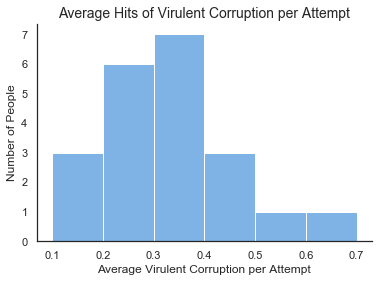

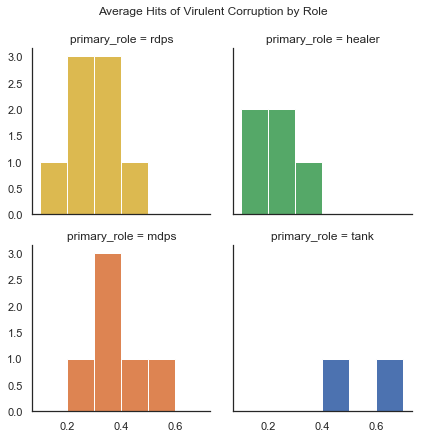

Mean is 0.333111 per attempt.
Median is 0.329897 per attempt.
Max attempts by player is 296.


In [45]:
la.collect_stats(data=orbs, master_list=master_list, player_list=player_list, 
                 boss_name="G'huun", boss_id=2122, spell_name="Virulent Corruption", 
                 analysis_columns=['hits'], min_attempts=70, bins=bins)

### Malignant Growth
ID: 274577

In [46]:
growths = wl.damage_taken(api_key, master_list, 274577, boss_id=2122,  
                       hit_type='hitCount')

Player added: Ayriea
Player added: Shadowbaine
Player added: Toy
Player added: Grombrindal
Player added: Brian
Player added: Velsummers
Player added: Velryssa
Player added: Mythrose
Player added: Psychodruid
Player added: Illestra
Player added: Vampyric
Player added: Draigo
Player added: Vaelyra
Player added: Earrl
Player added: Acturus
Player added: Tawn
Player added: Kopyelock
Player added: Metonymy
Player added: Jampers
Player added: Petrol
Player added: Acturus
Player added: Psychodruid
Player added: Draigo
Player added: Mythrose
Player added: Jampers
Player added: Velsummers
Player added: Grombrindal
Player added: Uuglei
Player added: Illestra
Player added: Petrol
Player added: Velryssa
Player added: Earrl
Player added: Metonymy
Player added: Tawn
Player added: Vampyric
Player added: Stradlock
Player added: Brian
Player added: Vaelyra
Player added: Acturus
Player added: Ayriea
Player added: Metonymy
Player added: Draigo
Player added: Grombrindal
Player added: Tawn
Player added: Br

In [49]:
bins = np.arange(0, 0.45, 0.05)

         player  hits  fight_count primary_role  av_count
8     Kopyelock    12          295         rdps  0.040678
14    Stradlock    10          225         rdps  0.044444
1        Ayriea    15          296         rdps  0.050676
11       Petrol    17          296         rdps  0.057432
19     Vampyric    13          224         mdps  0.058036
18      Vaelyra    11          184         mdps  0.059783
10     Mythrose    21          289       healer  0.072664
0       Acturus    19          258       healer  0.073643
21   Velsummers    22          271       healer  0.081181
15         Tawn    24          285         rdps  0.084211
12  Psychodruid    25          293         rdps  0.085324
13  Shadowbaine    25          291         rdps  0.085911
5   Grombrindal    28          296         mdps  0.094595
2         Brian    28          296         mdps  0.094595
7       Jampers    30          293       healer  0.102389
16          Toy    29          244         mdps  0.118852
9      Metonym

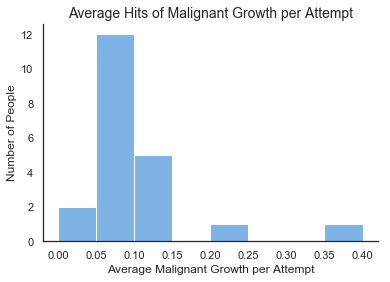

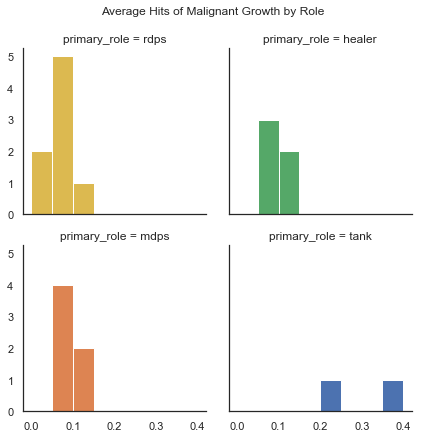

Mean is 0.104040 per attempt.
Median is 0.085324 per attempt.
Max attempts by player is 296.


In [50]:
la.collect_stats(data=growths, master_list=master_list, player_list=player_list, 
                 boss_name="G'huun", boss_id=2122, spell_name="Malignant Growth", 
                 analysis_columns=['hits'], min_attempts=70, bins=bins)

### Power Matrix Dunk
ID: 263372

In [51]:
dunks = wl.buff_duration(api_key, master_list, 263372, boss_id=2122, buff=False)

Player added: Psychodruid
Player added: Vaelyra
Player added: Velryssa
Player added: Earrl
Player added: Draigo
Player added: Tawn
Player added: Grombrindal
Player added: Ayriea
Player added: Brian
Player added: Velsummers
Player added: Kopyelock
Player added: Shadowbaine
Player added: Stradlock
Player added: Petrol
Player added: Vampyric
Player added: Illestra
Player added: Metonymy
Player added: Velsummers
Player added: Earrl
Player added: Draigo
Player added: Metonymy
Player added: Psychodruid
Player added: Stradlock
Player added: Tawn
Player added: Shadowbaine
Player added: Grombrindal
Player added: Kopyelock
Player added: Vampyric
Player added: Velryssa
Player added: Ayriea
Player added: Illestra
Player added: Brian
Player added: Petrol
Player added: Metonymy
Player added: Illestra
Player added: Grombrindal
Player added: Petrol
Player added: Earrl
Player added: Brian
Player added: Tawn
Player added: Kopyelock
Player added: Velryssa
Player added: Draigo
Player added: Vampyric
Playe

In [52]:
dunks.head()

,log_id,spell_id,player,duration,uses
0,9t1JjYfvbZkyWCGP,263372,Psychodruid,149639,34
1,9t1JjYfvbZkyWCGP,263372,Vaelyra,190564,13
2,9t1JjYfvbZkyWCGP,263372,Velryssa,344994,25
3,9t1JjYfvbZkyWCGP,263372,Earrl,247773,28
4,9t1JjYfvbZkyWCGP,263372,Draigo,136339,21


In [62]:
soloers = ['Grombrindal', 'Velryssa', 'Vampyric', 'Vaelyra', 'Brian']
throwers = ['Ayriea', 'Velsummers', 'Kopyelock', 'Illestra', 'Metonymy', 'Tawn']
dunkers = ['Psychodruid', 'Earrl', 'Petrol', 'Draigo', 'Shadowbaine', 'Stradlock']

In [58]:
debuff_times = dunks.groupby('player')['duration'].sum()\
               /dunks.groupby('player')['uses'].sum()
debuff_times.sort_values()

player
Toy             4777.476190
Psychodruid     5199.013298
Shadowbaine     5353.751244
Velsummers      5390.137457
Ayriea          5634.787958
Kopyelock       6207.037288
Draigo          6304.125926
Tawn            6382.321739
Metonymy        6946.752336
Stradlock       6967.750000
Illestra        7273.197279
Petrol          8257.395683
Earrl           9108.320635
Vaelyra        10762.909091
Uuglei         12057.000000
Velryssa       12151.536278
Vampyric       13185.375000
Grombrindal    13580.955729
Brian          15554.350230
dtype: float64

In [64]:
dunk_list = []
for thrower, dunker in zip(throwers, dunkers):
    dunk_list.append({
        'thrower': thrower,
        'dunker': dunker,
        'av_t_duration': debuff_times[thrower],
        'av_d_duration': debuff_times[dunker],
        'combined_duration': debuff_times[thrower] + debuff_times[dunker]
    })

dunk_df = pd.DataFrame(dunk_list, 
                       columns=['thrower', 'dunker', 
                                'av_t_duration', 'av_d_duration', 
                                'combined_duration'])

dunk_df.sort_values('combined_duration')

,thrower,dunker,av_t_duration,av_d_duration,combined_duration
0,Ayriea,Psychodruid,5634.787958,5199.013298,10833.801256
4,Metonymy,Shadowbaine,6946.752336,5353.751244,12300.503580
5,Tawn,Stradlock,6382.321739,6967.750000,13350.071739
3,Illestra,Draigo,7273.197279,6304.125926,13577.323205
2,Kopyelock,Petrol,6207.037288,8257.395683,14464.432972
1,Velsummers,Earrl,5390.137457,9108.320635,14498.458092


In [65]:
dunks.to_csv('guild_awards/ghuun_dunk_data.csv', index=False)
dunk_df.to_csv('guild_awards/ghuun_dunk_pair_analysis.csv', index=False)